In [1]:
try:
  # This command only in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [2]:
# Get project files
!wget https://cdn.freecodecamp.org/project-data/cats-and-dogs/cats_and_dogs.zip

!unzip cats_and_dogs.zip

PATH = 'cats_and_dogs'

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')
test_dir = os.path.join(PATH, 'test')

# Get number of files in each directory. The train and validation directories
# each have the subdirecories "dogs" and "cats".
total_train = sum([len(files) for r, d, files in os.walk(train_dir)])
total_val = sum([len(files) for r, d, files in os.walk(validation_dir)])
total_test = len(os.listdir(test_dir))

# Variables for pre-processing and training.
batch_size = 128
epochs = 15
IMG_HEIGHT = 150
IMG_WIDTH = 150

Streaming output truncated to the last 5000 lines.
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.60.jpg  
  inflating: cats_and_dogs/train/dogs/dog.858.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.858.jpg  
  inflating: cats_and_dogs/train/dogs/dog.680.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.680.jpg  
  inflating: cats_and_dogs/train/dogs/dog.694.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.694.jpg  
  inflating: cats_and_dogs/train/dogs/dog.864.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.864.jpg  
  inflating: cats_and_dogs/train/dogs/dog.870.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.870.jpg  
  inflating: cats_and_dogs/train/dogs/dog.871.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.871.jpg  
  inflating: cats_and_dogs/train/dogs/dog.865.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.865.jpg  
  inflating: cats_and_dogs/train/dogs/dog.695.jpg  
  inflating: __MACOSX/cats_and

In [3]:
# 3
train_image_generator = ImageDataGenerator(rescale = 1./255)
validation_image_generator = ImageDataGenerator(rescale = 1./255)
test_image_generator = ImageDataGenerator(rescale = 1./255)

train_data_gen = train_image_generator.flow_from_directory(
    directory = train_dir,
    batch_size = batch_size,
    target_size = (IMG_HEIGHT, IMG_WIDTH),
    class_mode = "binary",
    shuffle = True
)
# Val is same as train
val_data_gen = validation_image_generator.flow_from_directory(
    directory = validation_dir,
    batch_size = batch_size,
    target_size = (IMG_HEIGHT, IMG_WIDTH),
    class_mode = "binary",
    shuffle = True
)
# Test is same as train but without shuffle
test_data_gen = test_image_generator.flow_from_directory(
    directory = PATH,
    batch_size = batch_size,
    target_size = (IMG_HEIGHT, IMG_WIDTH),
    classes = ["test"],  # Specify the test class (directory) here from the root path
    shuffle = False
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 50 images belonging to 1 classes.


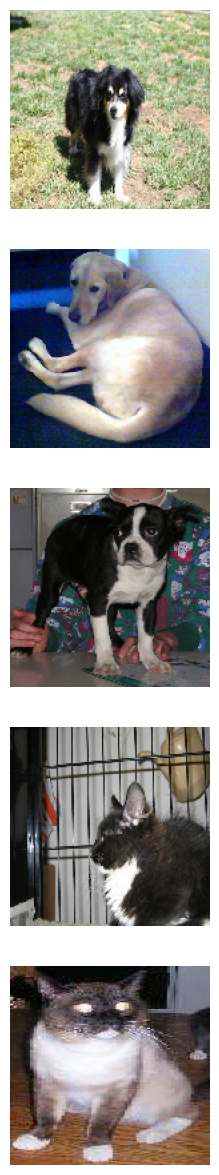

In [4]:
# 4
def plotImages(images_arr, probabilities = False):
    fig, axes = plt.subplots(len(images_arr), 1, figsize=(5,len(images_arr) * 3))
    if probabilities is False:
      for img, ax in zip( images_arr, axes):
          ax.imshow(img)
          ax.axis('off')
    else:
      for img, probability, ax in zip( images_arr, probabilities, axes):
          ax.imshow(img)
          ax.axis('off')
          if probability > 0.5:
              ax.set_title("%.2f" % (probability*100) + "% dog")
          else:
              ax.set_title("%.2f" % ((1-probability)*100) + "% cat")
    plt.show()

sample_training_images, _ = next(train_data_gen)
plotImages(sample_training_images[:5])


In [5]:
# 5
train_image_generator = ImageDataGenerator(
    rescale = 1./255,
    # Random transformation applied below
    rotation_range = 10,
    brightness_range = [0.8, 1.2],   # Darken if less than 1, brighten if more than 1
    zoom_range = 0.2,   # Zoom from range (1-this) to (1+this)
    horizontal_flip = True,
    vertical_flip = True
    )


Found 2000 images belonging to 2 classes.


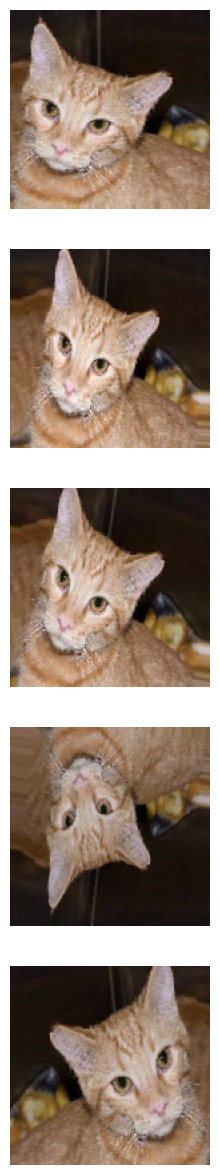

In [6]:
# 6
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='binary')

augmented_images = [train_data_gen[0][0][0] for i in range(5)]

plotImages(augmented_images)

In [7]:
# 7
model = Sequential()

# Conv2D -> pooling -> Conv2D -> Pooling -> Conv2D -> Flatten -> Dense -> Dense (2)
model.add(Conv2D(32, (3,3), activation = "relu", input_shape = (150, 150, 3)))
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(64, (3,3), activation = "relu"))
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(64, (3,3), activation = "relu"))
model.add(MaxPooling2D((2,2)))

model.add(Flatten())
model.add(Dense(64, activation = "relu"))
model.add(Dense(1, activation = "sigmoid"))

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 18496)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     1,183,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,240,193 (4.73 MB)

 Trainable params: 1,240,193 (4.73 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# Compile model
model.compile(
    optimizer = "adam",
    loss = "binary_crossentropy",  # For binary classification
    metrics = ["accuracy"]
)

In [9]:
# 8
history = model.fit(
    x = train_data_gen,
    epochs = epochs,
    steps_per_epoch = int(np.ceil(total_train / batch_size)),
    validation_data = val_data_gen,
    validation_steps = int(np.ceil(total_val / batch_size))
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 98s 6s/step - accuracy: 0.5051 - loss: 0.7715 - val_accuracy: 0.5310 - val_loss: 0.6942
Epoch 2/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 96s 6s/step - accuracy: 0.5144 - loss: 0.6889 - val_accuracy: 0.5700 - val_loss: 0.6596
Epoch 3/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 143s 6s/step - accuracy: 0.5652 - loss: 0.6599 - val_accuracy: 0.5250 - val_loss: 0.6516
Epoch 4/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 104s 6s/step - accuracy: 0.5862 - loss: 0.6521 - val_accuracy: 0.5910 - val_loss: 0.6521
Epoch 5/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 106s 7s/step - accuracy: 0.6247 - loss: 0.6415 - val_accuracy: 0.6390 - val_loss: 0.6266
Epoch 6/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 133s 6s/step - accuracy: 0.6545 - loss: 0.6056 - val_accuracy: 0.6990 - val_loss: 0.5909
Epoch 7/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 141s 6s/step - accuracy: 0.6908 - loss: 0.5922 - val_accuracy: 0.6720 - val_loss: 0.6002
Epoch 8/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 94s 6s/step - accuracy: 0.6647 - loss: 0.6115 - val_accuracy: 0.6690 - val_

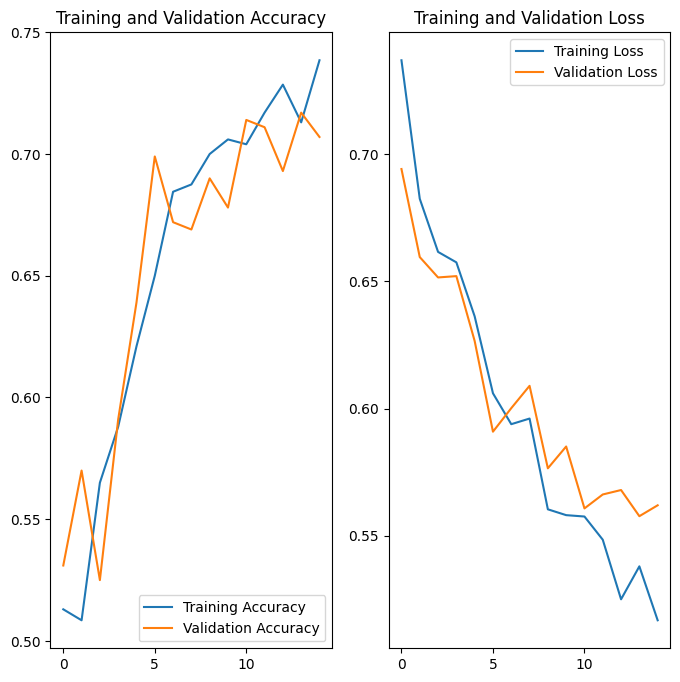

In [10]:
# 9
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [22]:
# 10
# Make prediction on test_data_gen
probabilities = model.predict(x = test_data_gen)

# Prob >= 0.5 is rounded to 1
probabilities = np.rint(probabilities)

# Flatten the probabilities
probabilities = probabilities.flatten()
probabilities

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 580ms/step


array([0., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1.,
       1., 0., 1., 0., 1., 0., 1., 1., 0., 1., 1., 0., 1., 1., 0., 1., 1.,
       0., 1., 1., 1., 0., 0., 1., 0., 1., 1., 0., 1., 1., 0., 1., 0.],
      dtype=float32)

In [23]:
# 11
answers =  [1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
            1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0,
            1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
            1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1,
            0, 0, 0, 0, 0, 0]

correct = 0

for probability, answer in zip(probabilities, answers):
  if round(probability) == answer:
    correct +=1

percentage_identified = (correct / len(answers)) * 100

passed_challenge = percentage_identified >= 63

print(f"Your model correctly identified {round(percentage_identified, 2)}% of the images of cats and dogs.")

if passed_challenge:
  print("You passed the challenge!")
else:
  print("You haven't passed yet. Your model should identify at least 63% of the images. Keep trying. You will get it!")

Your model correctly identified 64.0% of the images of cats and dogs.
You passed the challenge!
